# 📘 `day3_4_parking_path_control.ipynb` Structure

In [ ]:
# 📘 Project File: day3_4_parking_path_control.ipynb

# ├── ✅ Step 1: Predict Strategy (MLP)
# │       └── Use trained model to classify:
# │           - Forward Perpendicular
# │           - Reverse Parallel
# │           - Cannot Park
#
# ├── ✅ Step 2: Generate p0, p1, p2
# │       └── Use `generate_control_points(...)`
# │           based on strategy, car, and spot dimensions
#
# ├── ✅ Step 3: Generate Bezier Path
# │       └── Create smooth curve using `generate_bezier_curve(...)`
# │           - Returns 50 (x, y) path points
#
# ├── ✅ Step 4: Animate Movement into Parking Spot
# │       ├── Add blue rectangle for car body
# │       ├── Add green rectangle for parking spot
# │       └── Animate car along bezier path (dot or box)
#
# ├── ✅ Step 5: (Optional) Export Animation
# │       ├── Save as `.gif` or `.mp4`
# │       └── Useful for reports or Streamlit app
#
# └── ✅ Step 6: Visualize `p1` Effect on Path
#         ├── Plot multiple Bezier curves with varying `p1`
#         └── Understand how midpoint affects parking shape

# 🚗 Day 3: Trajectory Planner
- generate_bezier_curve()
- Plot test

# 🎮 Day 4: Vehicle Controller
- calculate_vehicle_controls()
- Print instructions from Bezier path

# 🔹DAY 3 – Trajectory Planner

🎯 Goal: Implement a basic Bezier curve planner




✅ Tasks:

	1.	📌 Choose Planning Method
	•	Start with Bezier curve (simpler than A* or RRT)
	•	Input: start pose, end pose
	•	Output: list of (x, y) points

	2.	🧮 Implement Bezier Function
	•	Add to planner/bezier.py
	•	Define function: generate_bezier_path(start, end, control_points=...)
  
	3.	🔁 Test with dummy car & parking coordinates
	•	Plot using Matplotlib (optional for debug)

In [ ]:
import numpy as np

def generate_bezier_curve(p0, p1, p2, num_points=50):
    """
    Generate a quadratic Bezier curve path (2D).
    Inputs:
        p0, p1, p2: Tuples (x, y) of control points
        num_points: Number of steps in the curve
    Returns:
        curve: (num_points, 2) numpy array of x, y points
    """
    t = np.linspace(0, 1, num_points).reshape(-1, 1)  # shape (50,1)

    p0 = np.array(p0)  # shape (2,)
    p1 = np.array(p1)
    p2 = np.array(p2)

    curve = (1 - t)**2 * p0 + 2 * (1 - t) * t * p1 + t**2 * p2
    return curve

## Visualization to see how the generate_bezier_curve function works:

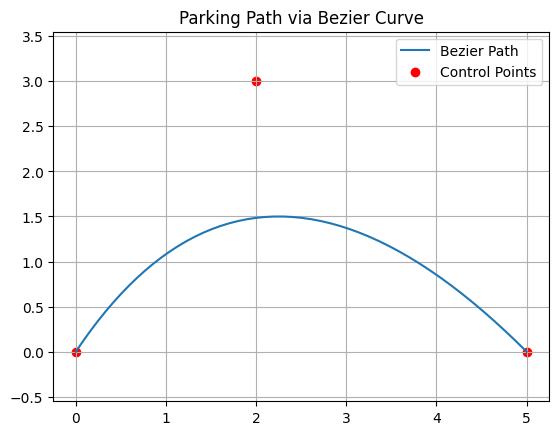

In [ ]:
import matplotlib.pyplot as plt

p0 = (0, 0)
p1 = (2, 3)
p2 = (5, 0)

curve = generate_bezier_curve(p0, p1, p2)

x, y = curve[:, 0], curve[:, 1]
plt.plot(x, y, label='Bezier Path')
plt.scatter(*zip(p0, p1, p2), color='red', label='Control Points')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title('Parking Path via Bezier Curve')
plt.show()

📍 What the Bezier Animation Shows

This animation visualizes the planned parking path the car will follow, based on 3 control points.

	•	The blue dot represents the car moving along the path.
	•	The blue curve is the smoothed parking trajectory.
	•	The red dashed line shows the control structure (start, curve influence, end).

This is the output of the Trajectory Planner module (Day 3).

It takes the MLP’s recommended strategy and plans how the car should move into the spot — forming the bridge between high-level decision and vehicle control.

- Point     Represents
- p0.   Starting position of the car (entry point)
- p1.   Steering midpoint (influences the curve)
- p2.   Target position in the parking spot


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Control points (x, y)
p0 = [0, 0]
p1 = [2, 3]
p2 = [5, 0]

# Bezier formula
def bezier(t, p0, p1, p2):
    return (1 - t)**2 * np.array(p0) + 2 * (1 - t) * t * np.array(p1) + t**2 * np.array(p2)

# Generate full curve in advance (optional)
num_frames = 101
t_values = np.linspace(0, 1, num_frames)
curve_points = [bezier(t, p0, p1, p2) for t in t_values]

# Set up plot
fig, ax = plt.subplots()
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 4)
ax.set_title('Quadratic Bezier Curve Animation')

# Draw control polygon
control_x = [p0[0], p1[0], p2[0]]
control_y = [p0[1], p1[1], p2[1]]
ax.plot(control_x, control_y, 'r--o', label='Control Points')

# Initialize plot elements
curve_line, = ax.plot([], [], 'b-', lw=2, label='Bezier Curve')
dot, = ax.plot([], [], 'bo')

# Animation update function
def animate(i):
    x_vals = [pt[0] for pt in curve_points[:i+1]]
    y_vals = [pt[1] for pt in curve_points[:i+1]]
    curve_line.set_data(x_vals, y_vals)
    dot.set_data([curve_points[i][0]], [curve_points[i][1]])  # Pass as lists
    return curve_line, dot

# Run animation
ani = FuncAnimation(fig, animate, frames=num_frames, interval=40, repeat=False)
ax.legend()
plt.grid(True)

# Show animation in Colab
HTML(ani.to_jshtml())

# Vehicle Controller! 🎮🛞

Today you’ll build the logic that translates the Bezier path into driving instructions — like turning and moving in small steps. This is where AI meets real-world control 🚗🤖

Goal:

Take the output Bezier path (list of (x, y) points), and convert it into:

	•	Turning angles (Δθ between segments)
	•	Movement distances (between points)
	•	High-level driving instructions like:

Turn to 20°, Move forward 1.5m
Turn to 25°, Move forward 1.0m
...

## 1. Define the Control Function


In [ ]:
import numpy as np

def calculate_vehicle_controls(path):
    """
    Given a 2D path (list of [x, y]), calculate steering angle and distance per step.

    Returns a list of instructions like:
    [("Turn to 45°", "Move 1.2m"), ...]
    """
    instructions = []
    for i in range(1, len(path)):
        x1, y1 = path[i - 1]
        x2, y2 = path[i]

        # Calculate distance between points
        dx = x2 - x1
        dy = y2 - y1
        distance = np.sqrt(dx**2 + dy**2)

        # Calculate angle (in degrees) relative to x-axis
        angle_rad = np.arctan2(dy, dx)
        angle_deg = np.degrees(angle_rad)

        # Normalize angle to [0, 360)
        angle_deg = (angle_deg + 360) % 360

        instructions.append((f"Turn to {angle_deg:.1f}°", f"Move {distance:.2f}m"))

    return instructions

## 2. Try it with the above Bezier path


In [ ]:
# Use the Bezier path from Day 3
p0 = (0, 0)
p1 = (2, 3)
p2 = (5, 0)
path = generate_bezier_curve(p0, p1, p2)

# Convert to instructions
controls = calculate_vehicle_controls(path)

# Display first 5 steps
for i, step in enumerate(controls[:5]):
    print(f"Step {i+1}: {step[0]}, {step[1]}")

Step 1: Turn to 55.6°, Move 0.15m
Step 2: Turn to 54.2°, Move 0.14m
Step 3: Turn to 52.7°, Move 0.14m
Step 4: Turn to 51.1°, Move 0.13m
Step 5: Turn to 49.5°, Move 0.13m


In [1]:
def generate_control_points(car_length, spot_length, distance_to_spot, strategy):
    """
    自动生成贝塞尔曲线的控制点 p0, p1, p2，用于规划停车路径。

    参数：
        car_length (float): 车辆长度（单位：米）
        spot_length (float): 车位长度（单位：米）
        distance_to_spot (float): 车与车位前缘之间的距离
        strategy (str): 停车策略（"Reverse Parallel", "Forward Perpendicular", "Cannot Park"）

    返回：
        p0, p1, p2: 三个控制点的坐标元组 (x, y)
    """
    # 起点：车在原点处
    p0 = (0, 0)

    if strategy == "Forward Perpendicular":
        # 车往前直角进入
        p2 = (0, distance_to_spot + spot_length - car_length/2)
        p1 = (1.5, p2[1] / 2)  # 弯曲中点稍微偏右一点

    elif strategy == "Reverse Parallel":
        # 车往后倒车入位
        p2 = (-2, - (spot_length - car_length/2))  # 停在后方车位
        p1 = (-1.5, p2[1] / 2)  # 控制弯曲程度

    else:  # Cannot Park
        return None, None, None

    return p0, p1, p2

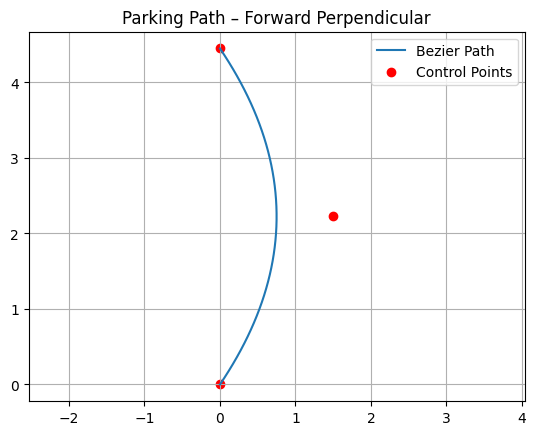

In [2]:
#添加调用示例和在 Colab 中画图的演示代码到你的脚本中:

import numpy as np
import matplotlib.pyplot as plt


def generate_control_points(car_length, spot_length, distance_to_spot, strategy):
    """
    自动生成贝塞尔曲线的控制点 p0, p1, p2，用于规划停车路径。

    参数：
        car_length (float): 车辆长度（单位：米）
        spot_length (float): 车位长度（单位：米）
        distance_to_spot (float): 车与车位前缘之间的距离
        strategy (str): 停车策略（"Reverse Parallel", "Forward Perpendicular", "Cannot Park"）

    返回：
        p0, p1, p2: 三个控制点的坐标元组 (x, y)
    """
    # 起点：车在原点处
    p0 = (0, 0)

    if strategy == "Forward Perpendicular":
        # 车往前直角进入
        p2 = (0, distance_to_spot + spot_length - car_length/2)
        p1 = (1.5, p2[1] / 2)  # 弯曲中点稍微偏右一点

    elif strategy == "Reverse Parallel":
        # 车往后倒车入位
        p2 = (-2, - (spot_length - car_length/2))  # 停在后方车位
        p1 = (-1.5, p2[1] / 2)  # 控制弯曲程度

    else:  # Cannot Park
        return None, None, None

    return p0, p1, p2


# ✅ Bezier 计算函数
def generate_bezier_curve(p0, p1, p2, num_points=50):
    t = np.linspace(0, 1, num_points).reshape(-1, 1)
    p0, p1, p2 = map(np.array, (p0, p1, p2))
    curve = (1 - t)**2 * p0 + 2 * (1 - t) * t * p1 + t**2 * p2
    return curve


# ✅ 示例调用
car_length = 4.5
spot_length = 5.5
distance_to_spot = 1.2
strategy = "Forward Perpendicular"

p0, p1, p2 = generate_control_points(car_length, spot_length, distance_to_spot, strategy)
if p0:
    curve = generate_bezier_curve(p0, p1, p2)

    # ✅ Colab 可视化
    x, y = curve[:, 0], curve[:, 1]
    plt.plot(x, y, label='Bezier Path')
    plt.scatter(*zip(p0, p1, p2), color='red', label='Control Points')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.title(f'Parking Path – {strategy}')
    plt.show()
else:
    print("❌ Cannot generate path – strategy is 'Cannot Park'")


In [3]:
# ✅ Step 1: 修改车辆尺寸和策略，自动生成路径
p0, p1, p2 = generate_control_points(
    car_length=4.5,
    spot_length=5.5,
    distance_to_spot=1.0,
    strategy='Forward Perpendicular'
)

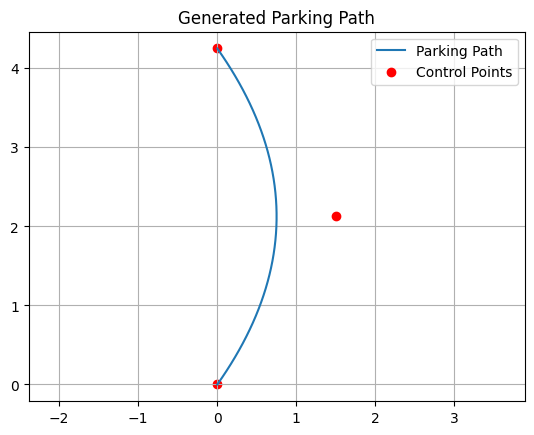

In [4]:
# 1. Plot the curve statically

# Show the full parking trajectory based on the generated control points.

curve = generate_bezier_curve(p0, p1, p2)

x, y = curve[:, 0], curve[:, 1]

plt.plot(x, y, label='Parking Path')
plt.scatter(*zip(p0, p1, p2), color='red', label='Control Points')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title('Generated Parking Path')
plt.show()

2. Animate the movement (optional)

You can create an animation to simulate the car’s movement along the path (good for presentation). You already used something like this earlier with FuncAnimation.

In [7]:
from google.colab import files
uploaded = files.upload()

Saving strategy_predictor.py to strategy_predictor (1).py


In [11]:
import os

# Rename the uploaded file to a clean name
os.rename("strategy_predictor (1).py", "strategy_predictor.py")

In [17]:
# 🔹 Step 1: Upload both model files
# mlp_strategy.pt
# scaler.pkl

from google.colab import files
uploaded = files.upload()

Saving mlp_strategy.pt to mlp_strategy.pt
Saving scaler.pkl to scaler.pkl


In [18]:
from strategy_predictor import predict_strategy
strategy, confidence, scores = predict_strategy(4.5, 1.8, 5.5, 2.5, 1.0, verbose=True)

📊 Strategy Confidence Scores:
Reverse Parallel: 20.57%
Forward Perpendicular: 75.54%
Cannot Park: 3.89%

🚘 Recommended Strategy: Forward Perpendicular (75.54% confidence)


📊 Strategy Confidence Scores:
Reverse Parallel: 20.57%
Forward Perpendicular: 75.54%
Cannot Park: 3.89%

🚘 Recommended Strategy: Forward Perpendicular (75.54% confidence)


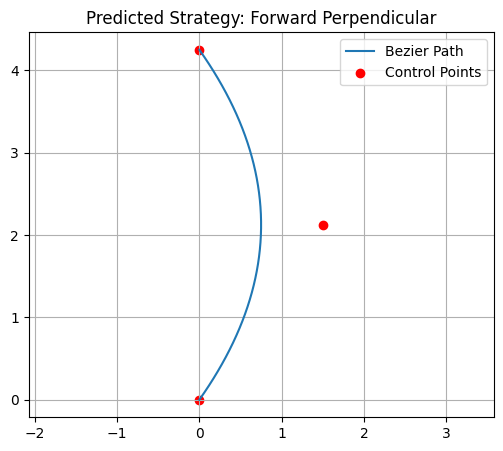

In [19]:
# 🧠 Predict strategy from car and spot dimensions
strategy, confidence, scores = predict_strategy(
    car_length=4.5,
    car_width=1.8,
    spot_length=5.5,
    spot_width=2.5,
    distance=1.0,
    verbose=True
)

# 📌 Generate control points based on predicted strategy
p0, p1, p2 = generate_control_points(
    car_length=4.5,
    spot_length=5.5,
    distance_to_spot=1.0,
    strategy=strategy
)

# 📈 Generate and plot the Bezier curve
curve = generate_bezier_curve(p0, p1, p2)

# 🖼️ Visualize
import matplotlib.pyplot as plt

x, y = curve[:, 0], curve[:, 1]
plt.figure(figsize=(6, 5))
plt.plot(x, y, label='Bezier Path')
plt.scatter(*zip(p0, p1, p2), color='red', label='Control Points')
plt.title(f"Predicted Strategy: {strategy}")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

### Full Animation Code

📊 Strategy Confidence Scores:
Reverse Parallel: 20.57%
Forward Perpendicular: 75.54%
Cannot Park: 3.89%

🚘 Recommended Strategy: Forward Perpendicular (75.54% confidence)
✅ GIF saved as: parking_animation.gif


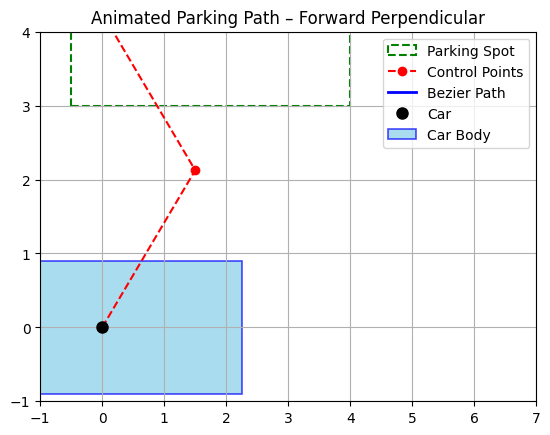

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Step 1: Predict strategy
strategy, confidence, scores = predict_strategy(
    car_length=4.5,
    car_width=1.8,
    spot_length=5.5,
    spot_width=2.5,
    distance=1.0,
    verbose=True
)

# Step 2: Generate control points
p0, p1, p2 = generate_control_points(
    car_length=4.5,
    spot_length=5.5,
    distance_to_spot=1.0,
    strategy=strategy
)

# Step 3: Generate curve
def bezier(t, p0, p1, p2):
    return (1 - t)**2 * np.array(p0) + 2 * (1 - t) * t * np.array(p1) + t**2 * np.array(p2)

t_values = np.linspace(0, 1, 100)
curve_points = [bezier(t, p0, p1, p2) for t in t_values]

# Step 4: Setup plot
fig, ax = plt.subplots()
ax.set_xlim(-1, 7)
ax.set_ylim(-1, 4)
ax.set_title(f'Animated Parking Path – {strategy}')
ax.grid(True)

# Add a rectangle to show the parking spot
import matplotlib.patches as patches

# Define car and spot dimensions (same as you used earlier)
car_length = 4.5
car_width = 1.8
spot_width = 2.5
spot_length = 5.5

# Example spot dimensions (adjust if needed)
spot_x = p2[0] - 0.5  # p2 is the endpoint of the path
spot_y = p2[1] - spot_width / 2  # center vertically around p2
spot_rect = patches.Rectangle(
    (spot_x, spot_y),           # bottom-left corner
    car_length,                 # width of the rectangle
    spot_width,                 # height (y-direction)
    linewidth=1.5,
    edgecolor='green',
    facecolor='none',
    linestyle='--',
    label='Parking Spot'
)
ax.add_patch(spot_rect)

# Draw control polygon
control_x = [p0[0], p1[0], p2[0]]
control_y = [p0[1], p1[1], p2[1]]
ax.plot(control_x, control_y, 'r--o', label='Control Points')

# Create plot elements to update
curve_line, = ax.plot([], [], 'b-', lw=2, label='Bezier Path')
car_dot, = ax.plot([], [], 'ko', markersize=8, label='Car')

# 🟦 Add moving car rectangle (initial dummy values)
car_rect = patches.Rectangle(
    (0, 0), car_length, car_width,
    linewidth=1.2,
    edgecolor='blue',
    facecolor='skyblue',
    alpha=0.7,
    label='Car Body'
)
ax.add_patch(car_rect)

# Step 5: Animation function
def animate(i):
    x_vals = [pt[0] for pt in curve_points[:i+1]]
    y_vals = [pt[1] for pt in curve_points[:i+1]]

    # Update line and dot
    curve_line.set_data(x_vals, y_vals)
    car_dot.set_data([x_vals[-1]], [y_vals[-1]]) # Pass as lists

    # Update car rectangle position
    x = x_vals[-1] - car_length / 2  # center the rectangle
    y = y_vals[-1] - car_width / 2
    car_rect.set_xy((x, y))  # move the car rectangle

    return curve_line, car_dot, car_rect

ani = FuncAnimation(fig, animate, frames=len(curve_points), interval=50, repeat=False)
ax.legend()

# Step 6: Display animation in Colab
HTML(ani.to_jshtml())

from matplotlib.animation import FuncAnimation, PillowWriter

# ✅ Save animation as GIF
gif_path = "parking_animation.gif"
ani.save(gif_path, writer=PillowWriter(fps=20))
print(f"✅ GIF saved as: {gif_path}")

### Export Bezier Parking Animation as GIF

In [23]:
!apt-get install imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10
  libwmflite-0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev inkscape
  poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fon

Download the .gif to your computer (optional)

In [31]:
from google.colab import files
files.download(gif_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 动态调整 p1 的贝塞尔路径可视化

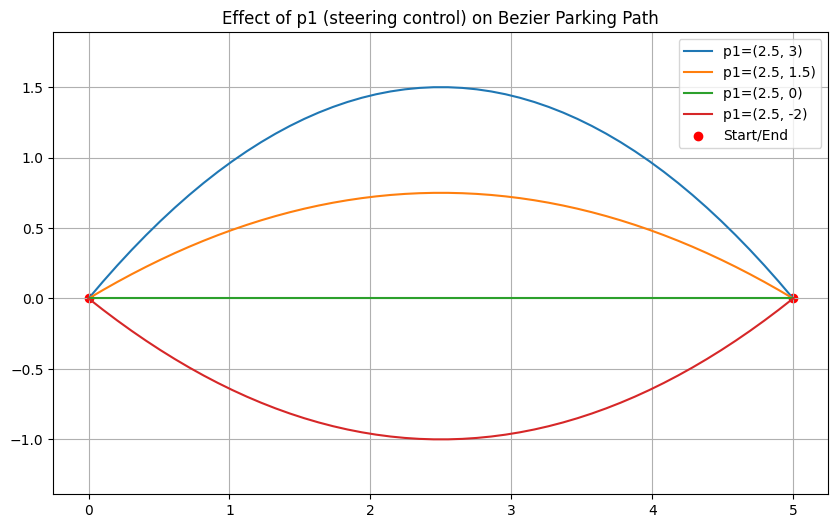

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_bezier_curve(p0, p1, p2, num_points=50):
    t = np.linspace(0, 1, num_points).reshape(-1, 1)
    p0 = np.array(p0)
    p1 = np.array(p1)
    p2 = np.array(p2)
    curve = (1 - t)**2 * p0 + 2 * (1 - t) * t * p1 + t**2 * p2
    return curve

# Fixed start and end points 固定起点和终点
p0 = (0, 0)         # Car starting point 车辆初始位置
p2 = (5, 0)         # Parking spot center 车位中心

#Try different midpoints p1 (simulate different steering approaches) 尝试多个不同的 p1 控制点
control_points = [
    (2.5, 3),       # 中间偏上（正常打方向）
    (2.5, 1.5),     # 稍微打方向
    (2.5, 0),       # sharper entry 直线进入
    (2.5, -2),      # 向下弯（错误方向）
]

plt.figure(figsize=(10, 6))

for p1 in control_points:
    curve = generate_bezier_curve(p0, p1, p2)
    x, y = curve[:, 0], curve[:, 1]
    plt.plot(x, y, label=f'p1={p1}')

# Mark start and end points 显示控制点
plt.scatter(*zip(p0, p2), c='red', label='Start/End')
plt.title('Effect of p1 (steering control) on Bezier Parking Path')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()